In [0]:
import numpy as np
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import cross_val_predict, cross_validate
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Steps to predict water level information

1.   Visualize the data and check whether there is a time series trend in the original data.
2.   Time series trend is found, so we should difference the data. After difference one time of our data, we apply KPSS test to check whether our data is stationary or not.
3. Kpss test shows the differenced data is stationary which indicates the parameters of ARIMA model d, which the time of difference need to be executed is one.
4. Apply ARIMA(p,1,q) model to the original data and use grid search to optimize p and q to get best accuracy. (0<=p<=2,0<=q<=2)
5. Employ optimized p and q value to ARIMA model. Then use ARIMA model to predict the water level information from 2020-03-01 to 2020-05-01 and visualize them.




In [0]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## data

In [0]:
jan1 = pd.read_csv('/content/drive/My Drive/water_level/2020/Jan.csv')
feb1 = pd.read_csv('/content/drive/My Drive/water_level/2020/Feb.csv')
mar1 = pd.read_csv('/content/drive/My Drive/water_level/2020/Mar.csv')


jan = pd.read_csv('/content/drive/My Drive/water_level/2019/Jan.csv')
feb = pd.read_csv('/content/drive/My Drive/water_level/2019/Feb.csv')
mar = pd.read_csv('/content/drive/My Drive/water_level/2019/Mar.csv')
apr = pd.read_csv('/content/drive/My Drive/water_level/2019/Apr.csv')
may = pd.read_csv('/content/drive/My Drive/water_level/2019/May.csv')
june = pd.read_csv('/content/drive/My Drive/water_level/2019/June.csv')
july = pd.read_csv('/content/drive/My Drive/water_level/2019/July.csv')
aug = pd.read_csv('/content/drive/My Drive/water_level/2019/Agu.csv')
sep = pd.read_csv('/content/drive/My Drive/water_level/2019/Sep.csv')
octe = pd.read_csv('/content/drive/My Drive/water_level/2019/Oct.csv')
nov = pd.read_csv('/content/drive/My Drive/water_level/2019/Nov.csv')
dec = pd.read_csv('/content/drive/My Drive/water_level/2019/Dec.csv')



In [0]:
frames = [jan, feb, mar, apr, may, june, july, aug, sep, octe, nov, dec, jan1, feb1, mar1]
data = pd.concat(frames, ignore_index=True)

In [0]:
data.tail()

,Date Time,Water Level,Sigma,O or I (for verified),F,R,L,Quality
110155,2020-04-01 23:30,0.612,0.005,1,0,0,0,p
110156,2020-04-01 23:36,0.609,0.010,1,0,0,0,p
110157,2020-04-01 23:42,0.606,0.006,1,0,0,0,p
110158,2020-04-01 23:48,0.620,0.005,1,0,0,0,p
110159,2020-04-01 23:54,0.612,0.004,1,0,0,0,p


In [0]:
data.rename(columns={'Date Time': 'date', ' Water Level': 'water_level'}, inplace = True)

In [0]:
data.head()

,date,water_level,Sigma,O or I (for verified),F,R,L,Quality
0,2019-01-01 00:00,0.501,0.064,0,0,0,0,v
1,2019-01-01 00:06,0.501,0.054,0,0,0,0,v
2,2019-01-01 00:12,0.537,0.071,0,0,0,0,v
3,2019-01-01 00:18,0.517,0.060,0,0,0,0,v
4,2019-01-01 00:24,0.504,0.068,0,0,0,0,v


In [0]:
dates = []
hour = []
month = []

for row in data['date']:
    dates.append(datetime.strptime(row.split()[0].replace("-",''),"%Y%m%d"))
    hour.append(int(row.split()[1].split(":")[0]))
    month.append(row.split()[0].split("-")[1].strip('0'))
    
data['dates'] = dates
data['hour'] = hour
data['month'] = month

### Water level change by dates

In [0]:
mean_by_dates = data.groupby('dates')['water_level'].mean().reset_index(name = 'daily_water_level')
mean_by_dates.head()

,dates,daily_water_level
0,2019-01-01,0.352196
1,2019-01-02,0.419113
2,2019-01-03,0.362208
3,2019-01-04,0.237271
4,2019-01-05,0.114304


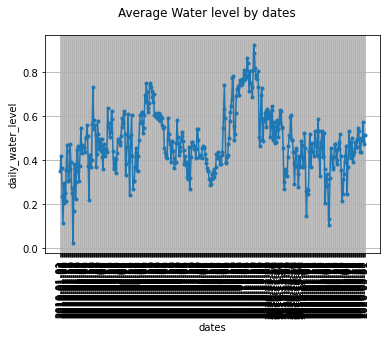

In [0]:
fig=plt.figure()
fig.suptitle('Average Water level by dates')
ax = mean_by_dates['daily_water_level'].plot(style = '.-')
plt.xticks(mean_by_dates.index, mean_by_dates['dates'].astype(str),rotation=90)
plt.rcParams["figure.figsize"] = (200,150)
plt.xlabel('dates')
plt.ylabel('daily_water_level')
plt.grid(True)

### Water levels change by each hour in one day

In [0]:
mean_by_dates_hour = data.groupby(['dates', 'hour'])['water_level'].mean().reset_index(name = 'dates_hour_water_level')
mean_by_dates_hour['dates_hour'] = mean_by_dates_hour['dates'].astype(str) + '-' + mean_by_dates_hour['hour'].astype(str)

In [0]:
mean_by_dates_hour.head()

,dates,hour,dates_hour_water_level,dates_hour
0,2019-01-01,0,0.5005,2019-01-01-0
1,2019-01-01,1,0.4513,2019-01-01-1
2,2019-01-01,2,0.4415,2019-01-01-2
3,2019-01-01,3,0.4641,2019-01-01-3
4,2019-01-01,4,0.4671,2019-01-01-4


In [0]:
fig=plt.figure()
fig.suptitle('Average Water Level by each hour in a date')
tp = mean_by_dates_hour[0:300]
ax = tp['dates_hour_water_level'].plot(style = '.-')
# plt.xticks(mean_by_dates_hour.index, mean_by_dates_hour['dates_hour'].values, rotation = 90)
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel('dates_hour')
plt.ylabel('Average_dates_hour_water_level')
plt.grid(True)
plt.show()

### Water Level change by month in one year of 2019 data 

In [0]:
mean_by_month= data.groupby('month')['water_level'].mean().reset_index(name = 'month_water_level')
mean_by_month['month'] = [int(i) for i in mean_by_month['month']]
mean_by_month.sort_values(by = 'month', ascending=True)
# mean_by_month.reset_index(inplace = True)
# mean_by_month.set_index('month', drop = True)
# mean_by_month

,month,month_water_level
0,1,0.495482
3,2,0.415658
4,3,0.459052
5,4,0.456796
6,5,0.637316
7,6,0.475253
8,7,0.431401
9,8,0.380970
10,9,0.611025
1,11,0.567921


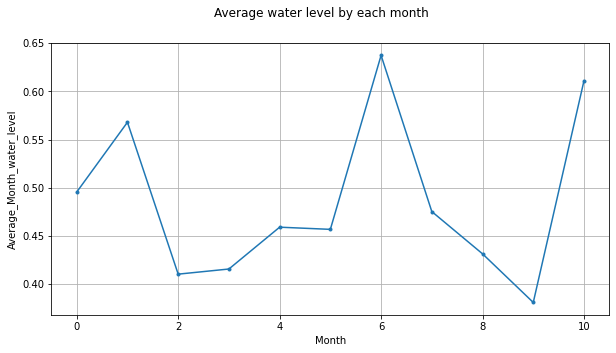

In [0]:
fig=plt.figure()
fig.suptitle('Average water level by each month')
ax = mean_by_month['month_water_level'].plot(style = '.-')
# plt.xticks(mean_by_month.index, mean_by_month['month'].values)
plt.rcParams["figure.figsize"] = (10,5)
plt.xlabel('Month')
plt.ylabel('Average_Month_water_level')
plt.grid(True)

## Time series model

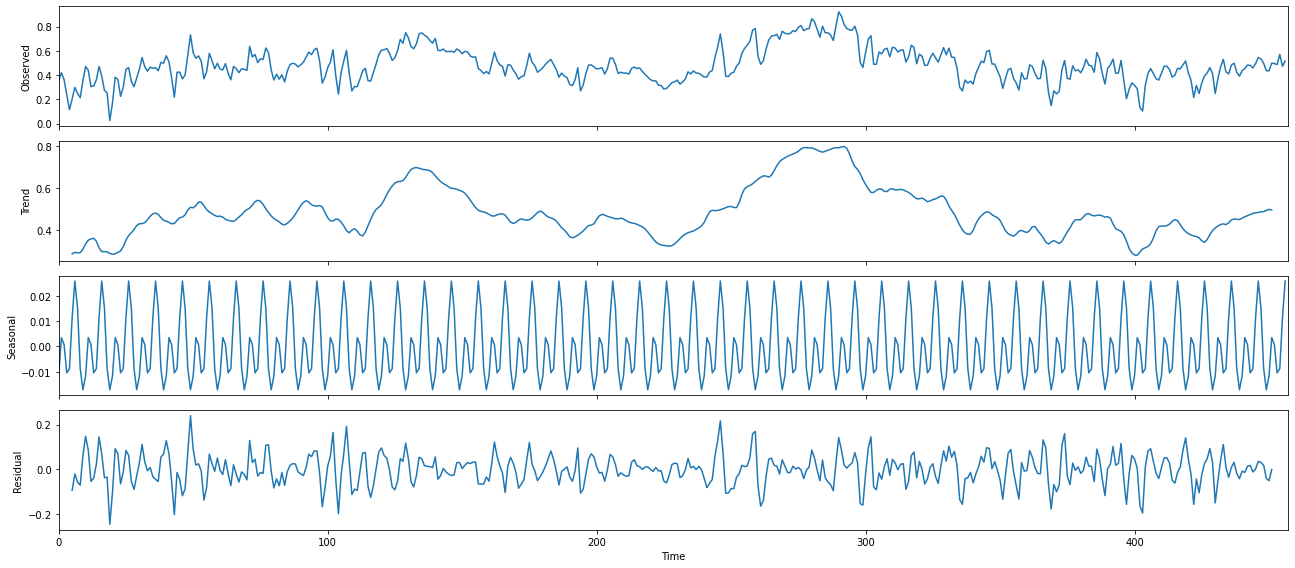

In [0]:
from pylab import rcParams
import statsmodels.api as sm

rcParams['figure.figsize'] = 18, 8
mean_by_dates.index = pd.DatetimeIndex(mean_by_dates['dates'])
decomposition = sm.tsa.seasonal_decompose(mean_by_dates.daily_water_level.values, freq = 10)
fig = decomposition.plot()
plt.show()

# Check whether there is a time series trend in our data.
*   From the plot of trend, there is an abvious time-series trend in out data. 

*   Also, from seasonal trend plot, we can also find that our data is affected by the seasonality. 


In [0]:
from statsmodels.tsa.stattools import adfuller

print(" > Is the data stationary ?")
dftest = adfuller(mean_by_dates.daily_water_level, autolag='BIC')
print("Test statistic = {:.3f}".format(dftest[0]))
print("P-value = {:.3f}".format(dftest[1]))
print("Critical values :")
for k, v in dftest[4].items():
    print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

 > Is the data stationary ?
Test statistic = -4.016
P-value = 0.001
Critical values :
	1%: -3.444868194858831 - The data is  stationary with 99% confidence
	5%: -2.867941416548597 - The data is  stationary with 95% confidence
	10%: -2.5701797149735146 - The data is  stationary with 90% confidence


We find that the data is not stationary. We need to difference the data.

## KPSS Test

Now out data is stationary.

In [0]:
# Trying to do forecasting with ARIMA
import itertools

p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
print('Examples of parameter combinations for Seasonal ARIMA...')
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[1]))
print('SARIMAX: {} x {}'.format(pdq[1], seasonal_pdq[2]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[3]))
print('SARIMAX: {} x {}'.format(pdq[2], seasonal_pdq[4]))

Examples of parameter combinations for Seasonal ARIMA...
SARIMAX: (0, 0, 1) x (0, 0, 1, 12)
SARIMAX: (0, 0, 1) x (0, 1, 0, 12)
SARIMAX: (0, 1, 0) x (0, 1, 1, 12)
SARIMAX: (0, 1, 0) x (1, 0, 0, 12)


In [0]:
best_aic = float("inf")
best_param = ""
best_param_seasonal = ""

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(mean_by_dates.daily_water_level,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            enforce_stationarity=True,
                                            enforce_invertibility=False)
            results = mod.fit()
            print('ARIMA{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
            if results.aic < best_aic:
                best_param = param
                best_param_seasonal = param_seasonal
                best_aic = results.aic
        except:
           continue
            
print("")
print("Best combination:",'ARIMA{}x{}12 - AIC:{}'.format(best_param, best_param_seasonal, best_aic))

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 0, 0, 12)12 - AIC:667.4958745943368
ARIMA(0, 0, 0)x(0, 0, 1, 12)12 - AIC:228.56087610024952
ARIMA(0, 0, 0)x(0, 1, 0, 12)12 - AIC:-494.62728809996435


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(0, 1, 1, 12)12 - AIC:-538.2971750201175
ARIMA(0, 0, 0)x(1, 0, 0, 12)12 - AIC:-487.3678612605704


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 0, 1, 12)12 - AIC:-526.567895868526


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 0, 12)12 - AIC:-531.163919343157


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 0)x(1, 1, 1, 12)12 - AIC:-573.4191196111644
ARIMA(0, 0, 1)x(0, 0, 0, 12)12 - AIC:117.04643609734335


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 0, 1, 12)12 - AIC:-242.65053819821026
ARIMA(0, 0, 1)x(0, 1, 0, 12)12 - AIC:-776.2801270869468


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(0, 1, 1, 12)12 - AIC:-848.2079118047767


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 0, 12)12 - AIC:-785.8323100311683


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 0, 1, 12)12 - AIC:-849.2938813160008


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 0, 12)12 - AIC:-833.6462534547754


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 0, 1)x(1, 1, 1, 12)12 - AIC:-882.4969717562573
ARIMA(0, 1, 0)x(0, 0, 0, 12)12 - AIC:-1067.786495528091


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 0, 1, 12)12 - AIC:-1067.380448317016
ARIMA(0, 1, 0)x(0, 1, 0, 12)12 - AIC:-762.1504276198182


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(0, 1, 1, 12)12 - AIC:-996.9973729274864
ARIMA(0, 1, 0)x(1, 0, 0, 12)12 - AIC:-1067.6237811865674


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 0, 1, 12)12 - AIC:-1066.30078466324


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 0, 12)12 - AIC:-890.3828055736924


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 0)x(1, 1, 1, 12)12 - AIC:-996.6221933324516
ARIMA(0, 1, 1)x(0, 0, 0, 12)12 - AIC:-1071.0363442982748


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 0, 1, 12)12 - AIC:-1070.7329879084182
ARIMA(0, 1, 1)x(0, 1, 0, 12)12 - AIC:-766.1586525100976


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(0, 1, 1, 12)12 - AIC:-1000.4244612742046
ARIMA(0, 1, 1)x(1, 0, 0, 12)12 - AIC:-1071.01635954683


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 0, 1, 12)12 - AIC:-1069.7736305591757


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 0, 12)12 - AIC:-896.0886818921173


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(0, 1, 1)x(1, 1, 1, 12)12 - AIC:-1000.1349881633731
ARIMA(1, 0, 0)x(0, 0, 0, 12)12 - AIC:-1067.0841629437448


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 0, 1, 12)12 - AIC:-1066.870017387626
ARIMA(1, 0, 0)x(0, 1, 0, 12)12 - AIC:-827.1562473034107


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(0, 1, 1, 12)12 - AIC:-1028.7514078125064


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 0, 12)12 - AIC:-1067.298427154881


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 0, 1, 12)12 - AIC:-1065.3130204891054


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 0, 12)12 - AIC:-939.9396153492357


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 0)x(1, 1, 1, 12)12 - AIC:-1031.2194385416308


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 0, 12)12 - AIC:-1071.264518186641


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 0, 1, 12)12 - AIC:-1071.3709534677282


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 0, 12)12 - AIC:-861.6023183200729


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(0, 1, 1, 12)12 - AIC:-1045.9894667776864


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 0, 12)12 - AIC:-1071.772627326823


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 0, 1, 12)12 - AIC:-1071.3925415280546


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 0, 12)12 - AIC:-968.2106488816542


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 0, 1)x(1, 1, 1, 12)12 - AIC:-1050.5385473826498
ARIMA(1, 1, 0)x(0, 0, 0, 12)12 - AIC:-1067.58507985419


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 0, 1, 12)12 - AIC:-1067.224327401441


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(0, 1, 0, 12)12 - AIC:-762.4006876165198
ARIMA(1, 1, 0)x(0, 1, 1, 12)12 - AIC:-996.9803622524385


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 0, 0, 12)12 - AIC:-1067.487502900458
ARIMA(1, 1, 0)x(1, 0, 1, 12)12 - AIC:-1066.2105360825076


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 0, 12)12 - AIC:-891.7757746645584


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 0)x(1, 1, 1, 12)12 - AIC:-996.6450732176935
ARIMA(1, 1, 1)x(0, 0, 0, 12)12 - AIC:-1105.808013269125


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 0, 1, 12)12 - AIC:-1105.879197962865


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 0, 12)12 - AIC:-818.8757172027892


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(0, 1, 1, 12)12 - AIC:-1031.7129428140765


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-1106.1634797173392


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 0, 1, 12)12 - AIC:-1104.7460136428545


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 0, 12)12 - AIC:-931.1642585343368


/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


ARIMA(1, 1, 1)x(1, 1, 1, 12)12 - AIC:-1031.9576614207804

Best combination: ARIMA(1, 1, 1)x(1, 0, 0, 12)12 - AIC:-1106.1634797173392


The result ARIMA(1, 1, 1) model is the best model, which shows d = 1, the same as we did before.

In [0]:
mean_by_dates.index = pd.DatetimeIndex(mean_by_dates['dates'])
mean_by_dates.index

DatetimeIndex(['2019-01-01', '2019-01-02', '2019-01-03', '2019-01-04',
               '2019-01-05', '2019-01-06', '2019-01-07', '2019-01-08',
               '2019-01-09', '2019-01-10',
               ...
               '2020-03-23', '2020-03-24', '2020-03-25', '2020-03-26',
               '2020-03-27', '2020-03-28', '2020-03-29', '2020-03-30',
               '2020-03-31', '2020-04-01'],
              dtype='datetime64[ns]', name='dates', length=457, freq=None)

In [0]:
# fit the ARIMA model
mod = sm.tsa.statespace.SARIMAX(mean_by_dates.daily_water_level,
                                order=(1, 1, 1),
                                seasonal_order=(1, 1, 0, 12),
                                enforce_stationarity=True,
                                enforce_invertibility=False)
results = mod.fit()
print(results.summary())

/usr/local/lib/python3.6/dist-packages/statsmodels/tsa/base/tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                  daily_water_level   No. Observations:                  457
Model:             SARIMAX(1, 1, 1)x(1, 1, 0, 12)   Log Likelihood                 469.582
Date:                            Tue, 28 Apr 2020   AIC                           -931.164
Time:                                    04:14:17   BIC                           -914.781
Sample:                                01-01-2019   HQIC                          -924.703
                                     - 04-01-2020                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7901      0.032     24.452      0.000       0.727       0.853
ma.L1         -1.0000      8.912   

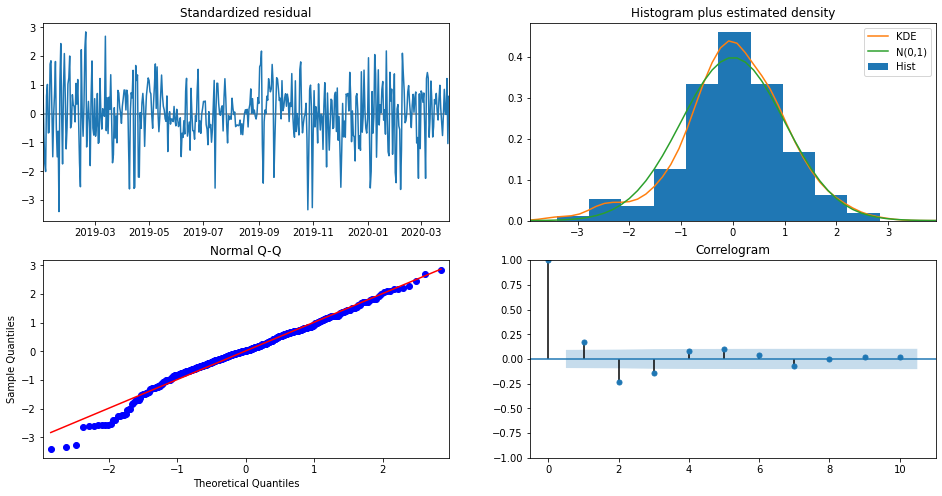

In [0]:
results.plot_diagnostics(figsize=(16, 8))
plt.show()


# Summary of prediction

1.   The standardized residual plot shows that the residuals distributed around zero evenly.
2.   The histogram plot shows that residual has a approximate normal distribution with mean of 0.
3. From the normal Q-Q plot, we can see that our predicted values are very close the actual values which means the predicted results are reliable.
4. From the ACF(autocorrelation function) plot, we can see that there is no significant signal shows there exist autocorrelaton between data.

Conclusion: The summary of prediction shows that the ARIMA model is reliable and accurate. 




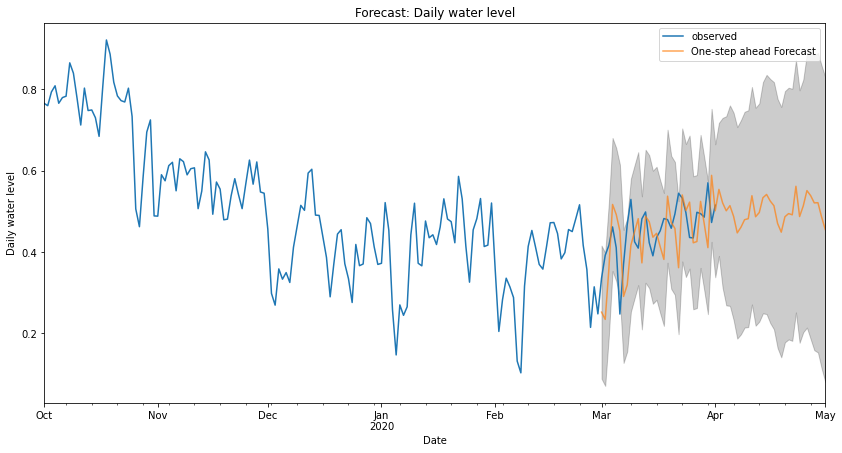

In [0]:
pred = results.get_prediction(start=pd.to_datetime('2020-03-01'), end=pd.to_datetime('2020-05-01'), dynamic=False)
pred_ci = pred.conf_int()
ax = mean_by_dates.daily_water_level['2019-10-01':].plot(label='observed')
pred.predicted_mean.plot(ax=ax, label='One-step ahead Forecast',  alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Date')
ax.set_ylabel('Daily water level')
ax.set_title("Forecast: Daily water level")
plt.legend()
plt.show()

From the forecast daily water level plot, it shows that the prediction is very close to the observed line which indicates that the model has a high prediction accuracy and good preformance. 